In [6]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from target_variables import *
from text_preprocess import preprocess_text
import pandas as pd
import shap
from lime.lime_text import LimeTextExplainer


def training_model(X, y, class_name):
    """
    Trains our model based on the given datasets. Adjust test sets accordingly

    Parameters:
    X : Concatenated text features into a single feature for analysis
    y : Target Variable

    Prints:
    Accuracy Score of Model

    Returns:
    Trained model, X_test, y_test.
    """
    print(" ---  Naive Bayes Model ---")
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.8, random_state=1)

    # Create a pipeline that transforms the data using TF-IDF and then fits the Naive Bayes classifier
    model = make_pipeline(TfidfVectorizer(), MultinomialNB())

    # Train the model
    model.fit(X_train, y_train)

    # Extract the trained vectorizer
    vectorizer = model.named_steps['tfidfvectorizer']

    print(f"Accuracy of {class_name}:", accuracy_score(
        y_test, model.predict(X_test)))

    return model, vectorizer, X_test, y_test

# Function to calculate a bias score for each description


def calculate_bias_score(description, biased_words_set):
    # Count the number of biased words in the description
    score = sum(word in description.split() for word in biased_words_set)
    return score

# Function to calculate a bias score for each description

def apply_lime_to_model(dataframe, X_test, y_test, model, class_names, biased_words):
    # Creating LimeTextExplainer
    print(" --- Applying LIME to Model ---")
    explainer = LimeTextExplainer(class_names=class_names)

    # Choose a random instance to explain
    idx = np.random.randint(0, len(X_test))
    exp = explainer.explain_instance(
        X_test.iloc[idx], model.predict_proba, num_features=10)

    # Extracting explanation and highlighting biased words
    explanation = exp.as_list()
    highlighted_text = X_test.iloc[idx]
    for word, _ in explanation:
        if word in biased_words:
            highlighted_text = highlighted_text.replace(word, f"**{word}**")

    # Displaying the explanation
    print('Document id: %d' % idx)
    print('Job Title:', dataframe.iloc[idx]['jobtitle'])
    # print('Job Description:', dataframe.iloc[idx]['jobdescription'])

    # Print the first 15 words of the job description
    print('Job Description (first 15 words):', ' '.join(dataframe.iloc[idx]['jobdescription'].split()[:30]))
    print('Probability(Bias) =',
          model.predict_proba([X_test.iloc[idx]])[0, 1])
    print('True class: %s' % class_names[y_test.iloc[idx]])
    print()

    return exp


# Load CSV into DataFrame
file_path_dice = '../../../datasets/dice_com-job_us_sample.csv'
file_path_linkedin = '../../../datasets/job_postings.csv'
dice_data = pd.read_csv(file_path_dice, low_memory=False)
linkedin_data = pd.read_csv(file_path_linkedin, low_memory=False)
dice_data = dice_data.astype(str)
linkedin_data = linkedin_data.astype(str)
biased_words_set = JobCategoryClassifier.biased_words

# Sample a subset of the data 
dice_sampled_data = dice_data.sample(frac=.1, random_state=1)
linkedin_sampled_data = linkedin_data.sample(frac=0.4, random_state=1)

# Remove duplicates
dice_sampled_data.drop_duplicates(inplace=True)
linkedin_sampled_data.drop_duplicates(inplace=True)


combined_data = pd.concat([dice_sampled_data, linkedin_sampled_data], ignore_index=True)
#combined_data = linkedin_sampled_data
#combined_data = dice_sampled_data

# Convert entire DataFrame to string before filling missing values
combined_data = combined_data.astype(str)
combined_data.fillna('unknown', inplace=True)
combined_data = combined_data[[
    'jobtitle', 'jobdescription', 'skills']]

linkedin_sampled_data.fillna('unknown', inplace=True)
linkedin_sampled_data = combined_data[[
    'jobtitle', 'jobdescription', 'skills']]

# Apply preprocessing to text columns
for column in ['jobtitle', 'jobdescription', 'skills']:
    combined_data[column] = combined_data[column].apply(preprocess_text)
    linkedin_sampled_data[column] = linkedin_sampled_data[column].apply(preprocess_text)


# Concatenate text features into a single feature for analysis
combined_data['combined_text'] = combined_data['jobtitle'] + ' ' + combined_data['jobdescription'] + \
    ' ' + \
    ' ' + combined_data['skills']

linkedin_sampled_data['combined_text'] = linkedin_sampled_data['jobtitle'] + ' ' + linkedin_sampled_data['jobdescription'] + \
    ' ' + \
    ' ' + linkedin_sampled_data['skills']

# Apply the function to create the target variable
# combined_data['find_biased_language'] = combined_data.apply(
#     lambda x: JobCategoryClassifier.find_biased_language(x['jobdescription']), axis


In [7]:
# Biased Language Detection
combined_data['naive_biased_words'] = combined_data['jobdescription'].apply(
    lambda x: JobCategoryClassifier.find_biased_language(x, 2))
# NB
bias_model, vectorizer_swe, X_test_bias, y_test_bias = training_model(
    combined_data['combined_text'], combined_data['naive_biased_words'], "Bias")

# Adding LIME to our NB job detection model.

exp = apply_lime_to_model(combined_data, X_test_bias, y_test_bias, bias_model, [
    'Not Bias', 'Bias'], biased_words_set)

# Visualize the explanation in a notebook
exp.show_in_notebook(text=True)

 ---  Naive Bayes Model ---
Accuracy of Bias: 0.7956286797322365
 --- Applying LIME to Model ---
Document id: 3145
Job Title: customer support specialist ami
Job Description (first 15 words): job description customer support specialist ami vivint is the home automation security company in the nation our account management innovation ami team continues to grow we are looking for high
Probability(Bias) = 0.0030635686931770106
True class: Not Bias



In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


 ------------------------------------------------------ 


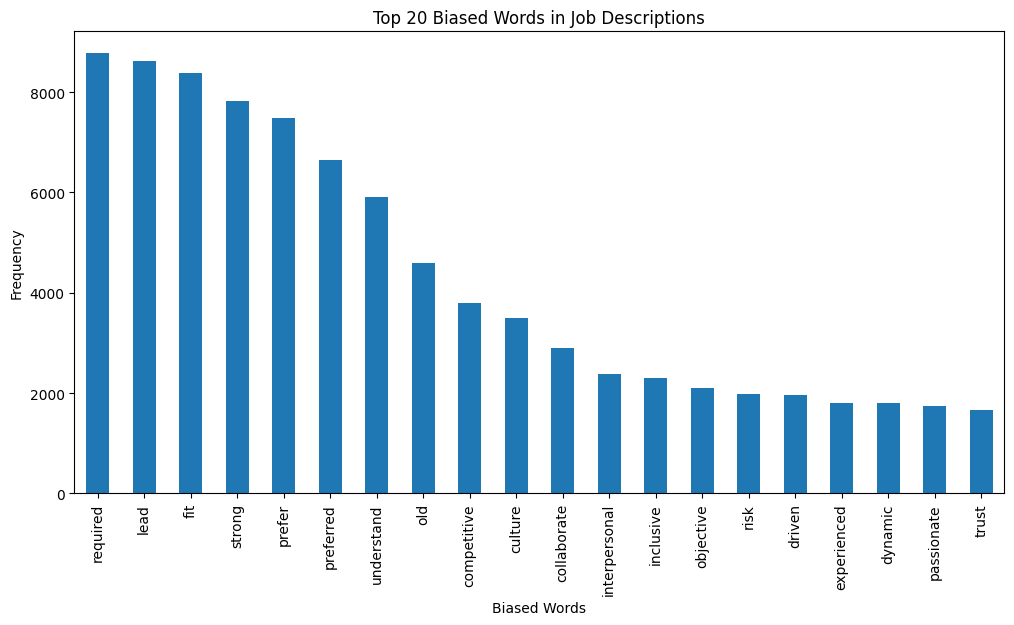

In [8]:
combined_data['biased_words'] = combined_data['jobdescription'].apply(
    lambda x: JobCategoryClassifier.find_biased_language(x, 1))

# Display job descriptions with biased words
biased_job_descriptions = combined_data[combined_data['biased_words'].apply(
    lambda x: len(x) > 0)]

print(" ------------------------------------------------------ ")

biased_words_list = sum(biased_job_descriptions['biased_words'], [])
word_freq = pd.Series(biased_words_list).value_counts()

# Plotting top N biased words
top_n = 20
word_freq[:top_n].plot(kind='bar', figsize=(12, 6))
plt.title(f"Top {top_n} Biased Words in Job Descriptions")
plt.ylabel("Frequency")
plt.xlabel("Biased Words")
plt.show()

Printing Bias Score for each job description . . .
                                                jobtitle  \
0      microsoft dynamics ax technical training senio...   
1                              business process engineer   
2                           peoplesoft manager  bhjob _    
3                   Node.js software engineer  developer   
4                              it security administrator   
...                                                  ...   
15493         lpn employee health trinity health livonia   
15494                              dp solvent specialist   
15495                                 rn  operating room   
15496  sterile processing lead  wilson county hospita...   
15497                     business analyst ahs help desk   

                                            biased_words  bias_score  
0      [dynamic, preferred, lead, strong, objective, ...           2  
1                                                 [lead]           1  
2              

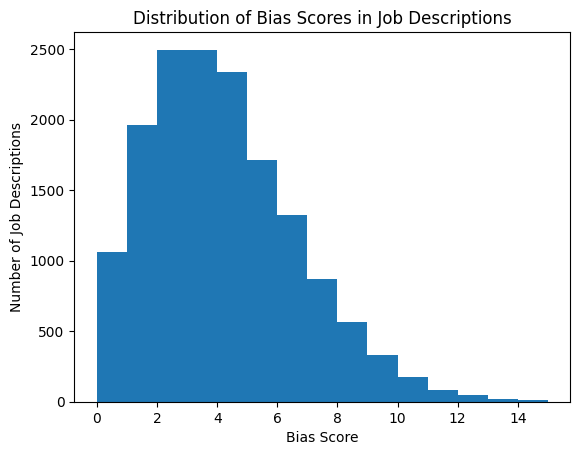

In [9]:
# Calculate bias score for each job description
print("Printing Bias Score for each job description . . .")
combined_data['bias_score'] = combined_data['jobdescription'].apply(
    lambda x: calculate_bias_score(x, biased_words_set))

# Displaying the bias scores along with job titles and descriptions
print(combined_data[['jobtitle', 'biased_words', 'bias_score']])

# Plotting the distribution of bias scores
# Calculate and print the average (mean) of the bias score
average_bias_score = combined_data['bias_score'].mean()
print("Average Bias Score:", average_bias_score)

# Calculate and print the standard deviation of the bias score
std_dev_bias_score = combined_data['bias_score'].std()
print("Standard Deviation of Bias Score:", std_dev_bias_score)

# Calculate IQR for bias score
Q1 = combined_data['bias_score'].quantile(0.25)
Q3 = combined_data['bias_score'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
outliers = combined_data[(combined_data['bias_score'] < lower_bound) | (
    combined_data['bias_score'] > upper_bound)]

print("Outliers start below:", lower_bound, "and above:", upper_bound)

plt.hist(combined_data['bias_score'], bins=range(
    min(combined_data['bias_score']), max(combined_data['bias_score']) + 1, 1))
plt.title('Distribution of Bias Scores in Job Descriptions')
plt.xlabel('Bias Score')
plt.ylabel('Number of Job Descriptions')
plt.show()

In [10]:
#  Sort the DataFrame by bias score in descending order
sorted_data = combined_data.sort_values(by='bias_score', ascending=False)

# Get the top 5 listings with the highest bias score
top_5_biased_listings = sorted_data.head(10)

# Display the top 5 biased job listings
print("Top 5 Listings with Highest Bias Score:")
print(top_5_biased_listings[['jobtitle', 'jobdescription', 'bias_score']])


Top 5 Listings with Highest Bias Score:
                                           jobtitle  \
5001          senior director security architecture   
5723                   sales reporting professional   
2956   director talent planning  performance remote   
14479          senior manager research  development   
3507     facilities project and program manager mid   
5887                     retail relationship banker   
3904   director talent planning  performance remote   
6844   director talent planning  performance remote   
12156      executive director  human resources  tsd   
2354                   software engineer ii  remote   

                                          jobdescription  bias_score  
5001   job description building off our cloud momentu...          15  
5723    br introduction at  work is more than a job  ...          15  
2956   strength in trust at onetrust we help business...          14  
14479  we are thrilled to announce an incredible oppo...          14  